# Data Preprocessing

## Missing Data

In [1]:
import pandas as pd
from io import StringIO

csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0'''
df = pd.read_csv(StringIO(csv_data))
df


,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [2]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [3]:
# drop rows with nan values
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [4]:
# drop columns with nan values
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [5]:
# drop only if all columns of a row is nan
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [6]:
# drop rows that have fewer than 4 real values
n = 4
df.dropna(thresh=n)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
# drop rows where nan appear in speficic columns
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


In [8]:
from sklearn.impute import SimpleImputer
import numpy as np

# insert mean of column values where there is nan values 
# this is useful for categorical features (when encoding names)
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [9]:
# cleaner approach
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


## Encoding categorical variables

In [10]:
df = pd.DataFrame([ ['green', 'M', 10.1,'class1'],
                    ['red', 'L', 12.3, 'class2'],
                    ['blue', 'XL', 14.4, 'class1']])
df.columns = ['color', 'size', 'price', 'classLabel']
df

,color,size,price,classLabel
0,green,M,10.1,class1
1,red,L,12.3,class2
2,blue,XL,14.4,class1


In [11]:
# if we want an ordered mapping between categorical variables, there is no function that can automatically
# derive the correct order of labels so we must provide the mapping ourselves

# let m = 1, l = m +1, xl = l +1 --> m=1, l=2, xl=3
size_map = {'XL' : 3, 'L' : 2, 'M' : 1}
df['size'] = df['size'].map(size_map)
df

,color,size,price,classLabel
0,green,1,10.1,class1
1,red,2,12.3,class2
2,blue,3,14.4,class1


In [12]:
# if we want to reverse the mapping done, reverse the corresponding key and values in the dict
inv_size_map = {val : key for key, val in size_map.items()}
df['size'] = df['size'].map(inv_size_map)
df

,color,size,price,classLabel
0,green,M,10.1,class1
1,red,L,12.3,class2
2,blue,XL,14.4,class1


In [13]:
# encoding class labels by enumerating the class labels

class_map = {label : idx for idx, label in enumerate(np.unique(df['classLabel']))}
df['classLabel'] = df['classLabel'].map(class_map)
df

,color,size,price,classLabel
0,green,M,10.1,0
1,red,L,12.3,1
2,blue,XL,14.4,0


In [14]:
# restore the class label mapping the exact same way as before

inv_class_map = {val : key for key, val in class_map.items()}
df['classLabel'] = df['classLabel'].map(inv_class_map)
df

,color,size,price,classLabel
0,green,M,10.1,class1
1,red,L,12.3,class2
2,blue,XL,14.4,class1


In [15]:
# sklearn's label encoder does this for us
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['classLabel'].values)
y

array([0, 1, 0])

In [16]:
# getting the inverse
le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

In [25]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:,0] = color_le.fit_transform(X[:,0])
X


array([[1, 'M', 10.1],
       [2, 'L', 12.3],
       [0, 'XL', 14.4]], dtype=object)

#### Danger

* One of the greatest pitfalls of stopping now and feeding the current values into a learning algorithm is that we have classified colors by integers so that the machine learning algorithm will interpret green as 1, red as 2, and blue as 0. I.e., it thinks red > green > blue. However, that is not the case. Thus, we should use a binary encoder to identify the color.  

* One-hot encoding solves this issue by creating new dummy features for each unique value in the categorical column. Here, we convert the color feature into three unique features (red, green, blue) where binary values can indicate the particular color of an example.

In [23]:
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:,0].reshape(-1,1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [26]:
from sklearn.compose import ColumnTransformer
# if we want selectively transform columsn in a multi-feature array, we can use the ColumnTransformer, which accepts a list of (name, transofrmer, column(s) tuples as follows)
X = df[['color', 'size', 'price']].values
col_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), [0]), # tuple of transformer type, class, and column index
    ('nothing', 'passthrough', [1,2]) #columns to leave untouched by index & passthrough argument
])
col_transformer.fit_transform(X).astype(float)


ValueError: could not convert string to float: 'M'

In [27]:
# integrated pandas method for one-hot encoding

pd.get_dummies(df[['color', 'size', 'price']])

,price,color_blue,color_green,color_red,size_L,size_M,size_XL
0,10.1,0,1,0,0,1,0
1,12.3,0,0,1,1,0,0
2,14.4,1,0,0,0,0,1


When using one-hot encoding, it introduces multi-collinearity. This increases computational complexity for matrix operations. Features that are highly correlated makes matrices more difficult to invert. To reduce correlation we can remove the last/first column without losing information. E.g. if we see a color is not red and not green, it must be blue 

In [28]:
# we can drop the first column by passing a True argument to the drop_first parameter

pd.get_dummies(df[['color', 'size', 'price']], drop_first=True)

,price,color_green,color_red,size_M,size_XL
0,10.1,1,0,1,0
1,12.3,0,1,0,0
2,14.4,0,0,0,1


In [29]:
# drop a redundant column via the OneHotEncoder

color_ohe = OneHotEncoder(categories='auto', drop='first')
col_transformer = ColumnTransformer([
    ('onehot', color_ohe, [0]),
    ('nothing', 'passthrough', [1,2])
])
col_transformer.fit_transform(X).astype(float)

ValueError: could not convert string to float: 'M'

## Feature Scaling

In [30]:
# load dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data')
df_wine.columns = ['class_label', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 
                   'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 
                   'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines', 'proline']
print('Class labels: ', np.unique(df_wine.class_label))
df_wine.head(10)

Class labels:  [1 2 3]


,class_label,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315_of_diluted_wines,proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
5,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
6,1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
7,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
8,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045
9,1,14.10,2.16,2.30,18.0,105,2.95,3.32,0.22,2.38,5.75,1.25,3.17,1510


In [31]:
#partition data into train and test data
from sklearn.model_selection import train_test_split

# normal convention for splits are 60:40, 70:30, 80:20 for small/medium sized datasets
# for large datasets with e.g. 100,000 examples, it is not uncommon with a 90:10 split 
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)


Feature scaling is crucial in data pipelines. Decision trees and random forests are two of very few algorithms that don't rely on feature scaling (scale-invariant). The majority, however, need features on the same scale. Assume we have one feature ranging from 1-10 and another from 1 to 100,000. Then,  
  
* Squared error functions will optimize weights according to the larger error in the second feature
* KNN & SVM with Euclidean distance measures will be dominated by the second feature axis.

Two methods:  
1. ***Normalization*** - Normalizes the feature column. Many linear models (logistic regression, SVM) initialize weights close to 0 or small random values close to 0, whcih can be an issue for normalization.
2. ***Standardization*** - Sets mean to 0 and standard deviation to 1. It does not change the shape of the distribution such that it maintains useful information on outliers, and has a broader range than normalization.

In [32]:
# normalization and standardization using scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
mms = MinMaxScaler()
ss = StandardScaler()
ex = np.arange(10).reshape(-1,1)
ex_norm = mms.fit_transform(ex)
ex_norm = mms.transform(ex)

ex_std = ss.fit_transform(ex)
ex_std = ss.transform(ex)

print('Standardized: ', ex_std, '\n')
print('Normalized: ', ex_norm)


Standardized:  [[-1.5666989 ]
 [-1.21854359]
 [-0.87038828]
 [-0.52223297]
 [-0.17407766]
 [ 0.17407766]
 [ 0.52223297]
 [ 0.87038828]
 [ 1.21854359]
 [ 1.5666989 ]] 

Normalized:  [[0.        ]
 [0.11111111]
 [0.22222222]
 [0.33333333]
 [0.44444444]
 [0.55555556]
 [0.66666667]
 [0.77777778]
 [0.88888889]
 [1.        ]]


In [33]:
# using numpy
ex = np.arange(10)
ex_std = (ex - np.mean(ex) ) / (np.std(ex))
ex_norm = (ex - np.min(ex)) / ( np.max(ex) - np.min(ex))
print('Standardized: ', ex_std, '\n')
print('Normalized: ', ex_norm)

Standardized:  [-1.5666989  -1.21854359 -0.87038828 -0.52223297 -0.17407766  0.17407766
  0.52223297  0.87038828  1.21854359  1.5666989 ] 

Normalized:  [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


## Selecting Meaningful Features

In cases of *high variance* (overfitting), the most common ways to reduce the generalization error are:  
* Collecting more training data  

* Introduce a penalty for complexity via regularization  

* Choose a simpler model with fewer parameters  

* Reduce the dimensionality of the data

In [34]:
# regularization in scikit-learn
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
# we choose l1 regularization with C = 1 (this is default and can be altered)
# the smaller C (C is inversely proportional to the regularization parameter) is, the smaller is the weights, vice versa
# also the lbfgs solver does not support l1 regularized loss optimization

X_train_std = ss.fit_transform(X_train)
X_train_std = ss.transform(X_train)
X_test_std = ss.fit_transform(X_test)
X_test_std = ss.transform(X_test)

lr.fit(X_train_std, y_train)
print("Training accuracy: ", lr.score(X_train_std, y_train))
print("Test accuracy: ", lr.score(X_test_std, y_test))


Training accuracy:  1.0
Test accuracy:  1.0


In [35]:
print("Intercepts: ", lr.intercept_)
print("Coefficients: ", lr.coef_)
# The coefficients correspond to our weights w_i. 
# Thus, zeros correspond to irrelevant features

Intercepts:  [-1.15468977 -1.06474309 -2.12175513]
Coefficients:  [[ 1.46989384  0.          0.51548121 -1.31102648  0.          0.
   1.24128735  0.          0.          0.          0.          0.68836221
   2.16768678]
 [-1.85480703 -0.31506091 -1.18247174  0.68807599 -0.15370942  0.
   0.60303838  0.          0.15500985 -1.20789635  1.25483083  0.
  -2.05484652]
 [ 0.          0.22660073  0.57325269  0.          0.12210596  0.
  -2.55589202 -0.13745494  0.          1.62340792 -0.90382729 -0.40001613
   0.        ]]


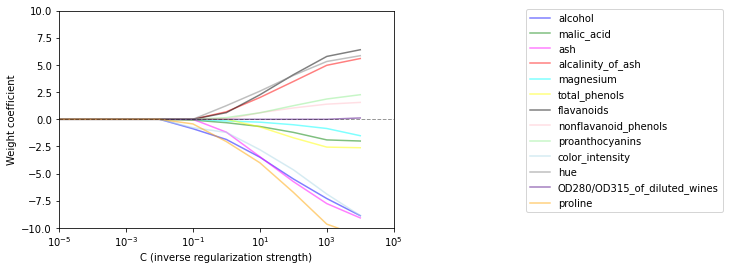

In [36]:
import matplotlib.pyplot as plt 

fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'magenta', 'red', 'cyan', 
          'yellow', 'black', 'pink', 'lightgreen', 
          'lightblue', 'gray', 'indigo', 'orange']

weights, params = [], []

for c in np.arange(-5,5):
    lr = LogisticRegression(penalty='l1', C=10.0**c, solver='liblinear', multi_class='ovr', random_state=1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.0**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:,column], label=df_wine.columns[column+1], color=color, alpha=0.5)

plt.axhline(0,color='black', linestyle='--', linewidth=1, alpha=0.4)
plt.xlim([10.0**(-5),10.0**5])
plt.ylim([-10, 10])
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='best')
ax.legend(loc='best', bbox_to_anchor=(1.38,1.03), ncol=1, fancybox=True)

## Sequential Feature Selection Algorithms
  
Greedy search algorithms tat are used to reduce an n-dimensional feature space to a k-dimensional feature space (k < n).  

The motivation is to automatically select a subset of features that are most relevant to the problem, reduce the generalization error by removing irrelevant features/noise, and improve comutational complexity.  
  
##### Sequential Backward Selection (**SBS**)
* aims to reduce dimesntionality of the intial feature subspace with a minimum performance reduction for the classifier to improve computational efficiency.
* It can improve predictive power if a model suffers from overfitting

##### Idea
* remove features from the full feature subset until the new feature subspace contains the desired number of features. To determine which feature is to be removed, we have a criterion function $J$ to be minimized. (e.g. difference in performance; the removed feature that minimizes this gets removed. I.e., the feature with least performance loss after removal is removed.)

We can outline the algorithm in 4 steps:
1. Initialize the algorithm with $k = n$, $p = \text{desired no. of features}$
2. Determine the feature $\hat{x}$ that maximizes the criterion: $\hat{x} = \argmax{J(X_{k} - x)} \text{ where } x \in X_{k}$
3. Remove the feature $\hat{x}$ from the feature set: $X_{k-1}  = X_{k} - \hat{x} \text{ ; } k = k -1$
4. Terminate if $k = p$, else go to step 2


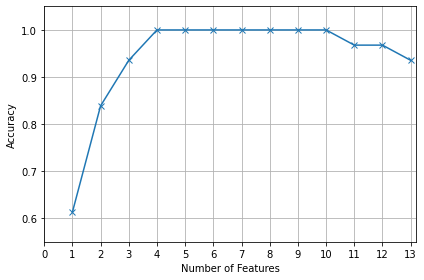

In [47]:
import sequential_backward_selection 
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
sbs = sequential_backward_selection.SBS(estimator=knn, k_features=1)
sbs.fit(X_train_std, y_train)

k_feature = [len(k) for k in sbs.subsets]

plt.plot(k_feature, sbs.scores, marker='x')
plt.ylim([0.55,1.05])
plt.xlim([0,13.2])
plt.ylabel('Accuracy')
plt.xlabel('Number of Features')
plt.xticks([i for i in range(len(k_feature)+1)])
plt.grid()
plt.tight_layout()
plt.show()

## Feature Importance using Random Forests

 1) flavanoids                      0.185507
 2) proline                         0.157696
 3) color_intensity                 0.140527
 4) alcohol                         0.123506
 5) OD280/OD315_of_diluted_wines    0.102537
 6) total_phenols                   0.065874
 7) hue                             0.052023
 8) alcalinity_of_ash               0.042504
 9) magnesium                       0.039159
10) malic_acid                      0.035162
11) proanthocyanins                 0.029724
12) nonflavanoid_phenols            0.016261
13) ash                             0.009519


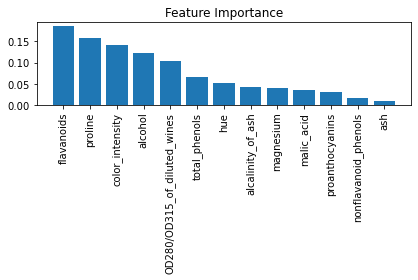

In [52]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=30, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s % f" % ( f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

The random forest techniwue comes with **an important note**. If two or more features are highly correlated, one feature can be highly ranked whereas the other is ranked low, so that the information in the others is not fully captured. However, when concerned about predictive performance this is not important but could be important when interpreting feature importance values.

In [58]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, 
                      threshold=0.1, # scaled importance of the feature from 0-1 where the sum of feature importance = 1
                      prefit=True)
X_selected = sfm.transform(X_train)

print('Number of columns that meet this threshold criterion: ', X_selected.shape[1])
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

Number of columns that meet this threshold criterion:  5
 1) flavanoids                     0.185507
 2) proline                        0.157696
 3) color_intensity                0.140527
 4) alcohol                        0.123506
 5) OD280/OD315_of_diluted_wines   0.102537
